**Baseline analysis**
--------------------

**Load raw data**

longitudinal AND cross sectional

In [65]:
# Load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pcntoolkit as pcn
import pickle

from scipy.stats import shapiro

from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical, plot_subcortical
from enigmatoolbox.utils.useful import reorder_sctx

ext_scripts_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/scripts')
os.chdir(ext_scripts_dir)

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

# importing custom functions
import clinics_desc_functions as custom

# set seed
custom.set_seed()

# formatiing
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# creating custom color palette
from matplotlib.colors import ListedColormap
from matplotlib.colors import ListedColormap

pk = sns.color_palette("RdBu_r", 20)

pk1 = pk[0:10]
pk1.reverse()
pk2 = pk[10:]
pk2.reverse()

ColdHot_r = ListedColormap([*pk1,*pk2])

# seaborn theme
sns.set_style("whitegrid")


Random seed 42 has been set.


In [66]:
# Define paths
project_dir = ('/home/barbora/Documents/Projects/Normative_Models')
models_dir = (os.path.join(project_dir,'ESO', 'models'))

cdata_dir = ('/home/barbora/Documents/Projects/2021_06_AZV_ESO/data')
fsdata_dir = os.path.join(project_dir,'ESO','fs_stats')
bdata_dir = os.path.join(project_dir,'ESO','backup','fit_external_long')
pretrained_dir = os.path.join(project_dir,'ESO','braincharts')

analysis_dir = os.path.join(project_dir, 'ESO', 'analyses', '01_Baseline')
images_dir = os.path.join(analysis_dir,'img')
os.makedirs(images_dir, exist_ok=True)

In [67]:
# get basic parameters for pretrained models
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

In [539]:
# parameters for Loading stuff
visit = 2
data_type = 'z'
preproc_type = 'cs'

In [540]:
# Load stuff

# Get correct paths
if preproc_type == 'cs':
    controls_dir = os.path.join(project_dir,'ESO','models','control_stability')
    patients_dir = os.path.join(project_dir,'ESO','models','pretrained')

elif preproc_type == 'long':
    controls_dir = os.path.join(project_dir,'ESO','models','control_stability_long')
    patients_dir = os.path.join(project_dir,'ESO','models','pretrained_long')

# Get correct type
if data_type == 'raw':
    cont = pd.read_csv(os.path.join(controls_dir, 'v'+str(visit)+'_common.csv'), index_col=0, sep=' ')
    cont = cont[[*['Category', 'sex', 'age', 'site'], *idp_ids]]
    pat = pd.read_csv(os.path.join(patients_dir, 'v'+str(visit)+'_pat.txt'), index_col=0, sep=' ')
    pat = pat[[*['Category', 'sex', 'age', 'site'], *idp_ids]]

    cont['category'] = 'control'
    cont['visit'] = str(visit)
    cont['preproc'] = preproc_type
    cont['scores'] = data_type

    pat['category'] = 'patient'
    pat['visit'] = str(visit)
    pat['preproc'] = preproc_type
    pat['scores'] = data_type

elif data_type == 'z':
    cont_c = pd.read_csv(os.path.join(controls_dir, 'v'+str(visit)+'_common.csv'), index_col=0, sep=' ')
    cont_c = cont_c[['Category', 'sex', 'age', 'site']]
    cont = custom.idp_concat(controls_dir, 'v'+str(visit)+'_Z.txt', idp_ids, 'v'+str(visit)+'_cont_z.txt')   
    cont = pd.read_csv(os.path.join(controls_dir, cont), sep=' ')
    cont.index = cont_c.index 
    cont = pd.concat([cont_c, cont], axis=1, join='inner')

    cont['category'] = 'control'
    cont['visit'] = str(visit)
    cont['preproc'] = preproc_type
    cont['scores'] = data_type

    pat_c = pd.read_csv(os.path.join(patients_dir, 'v'+str(visit)+'_pat.txt'), index_col=0)
    pat_c = pat_c[['Category', 'sex', 'age', 'site']]
    pat = custom.idp_concat(os.path.join(patients_dir, 'V'+str(visit)),'Z_predict.txt', idp_ids, 'v'+str(visit)+'_pat_z.txt', t_dir = patients_dir)   
    pat = pd.read_csv(os.path.join(patients_dir, pat), sep=' ')
    id = [i.split('_')[0] for i in pat_c.index]
    pat_c.index = id
    pat.index = id
    pat = pd.concat([pat_c, pat], axis=1, join='inner')

    pat['category'] = 'patient'
    pat['visit'] = str(visit)
    pat['preproc'] = preproc_type
    pat['scores'] = data_type



thick_id = [i for i in idp_ids if 'thickness'in i] 
sc_id = [i for i in idp_ids if 'thickness' not in i] 
sc_s_id = [i for i in sc_id if i.find('Vol')<0]

In [538]:
v1_pat = pat
v1_cont = cont

In [541]:
v2_pat = pat
v2_cont = cont

In [542]:
if preproc_type == 'cs':
    v1_pat = v1_pat.loc[v1_pat.index.intersection(v2_pat.index),:]
    v2_pat = v2_pat.loc[v1_pat.index.intersection(v2_pat.index),:]

data = pd.concat([v1_cont,v2_cont], axis = 0)
data = pd.concat([data,v1_pat], axis = 0)
data = pd.concat([data,v2_pat], axis = 0)
data = data.reset_index()
#data = pd.concat([cont,pat])
data.to_csv(os.path.join(analysis_dir, 'data_'+preproc_type+'_'+data_type+'.csv'), sep = ' ', index=True)

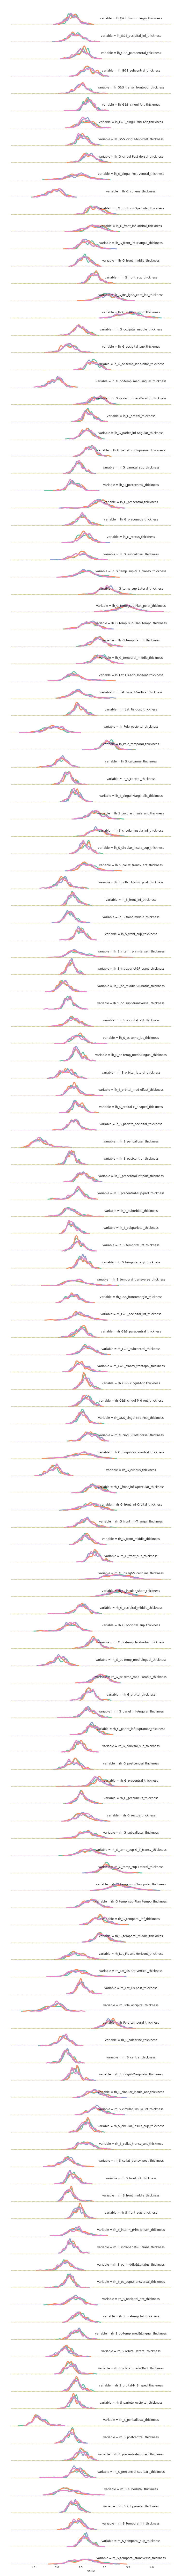

In [113]:
# All kdes on one figure - probably unnecessary long

# melt datatable with relevant columns
#pk = pd.melt(data_merge, id_vars=['age','sex','category'], value_vars=[*thick_id])
pk = pd.melt(data, id_vars=['age','sex','category', 'visit'], value_vars=[*thick_id])
pk['hue'] = pk['category'].astype(str) + ', ' + pk['visit'].astype(str)
pk = pk.sort_values(by=['category', 'visit'])

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
#pal = sns.cubehelix_palette(2, rot=-.25, light=.7)
g = sns.FacetGrid(pk, row="variable", hue='hue', aspect=10, height=1, palette='Set2')#pal

# Draw the densities in a few steps
g.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=False,
      fill=False, alpha=.1, linewidth=1)
g.map(sns.kdeplot, "value", clip_on=False,  lw=4, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=1, linestyle="--", color='y', clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


#g.map(label, "value")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
g.set_titles(x=.75, y=.2 )
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.savefig(os.path.join(images_dir,'v12_'+data_type+'_'+preproc_type+'_histograms'))
#plt.close()



**Computations using averaging of idps**
-------------------------------------------

In [544]:
rh_thick = [i for i in idp_ids if 'rh' in i]
lh_thick = [i for i in idp_ids if 'rh' in i]

data['rh_MeanThickness'] = data[rh_thick].median(axis=1)
data['lh_MeanThickness'] = data[lh_thick].median(axis=1)

thick_id = ['lh_MeanThickness', 'rh_MeanThickness']

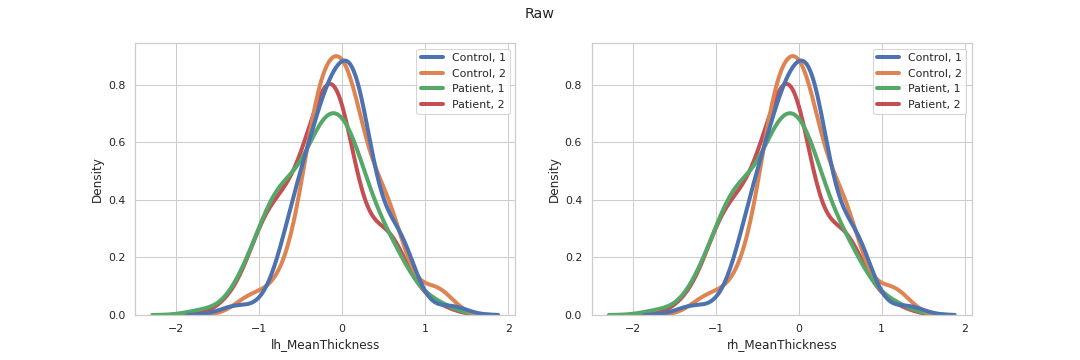

In [545]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

for i,id in enumerate(thick_id):
    data= data.sort_values(by=['Category', 'visit'], ascending=True)

    hue = data['Category'].astype(str) +', ' + data['visit'].astype(str) 
    sns.kdeplot(data=data, x=id, hue=hue, ax=ax[i], linewidth=4, common_norm=False)
    fig.suptitle('Raw')

plt.savefig(os.path.join(images_dir, 'hist_'+preproc_type+'_'+data_type+'_cat_visit_compar'))

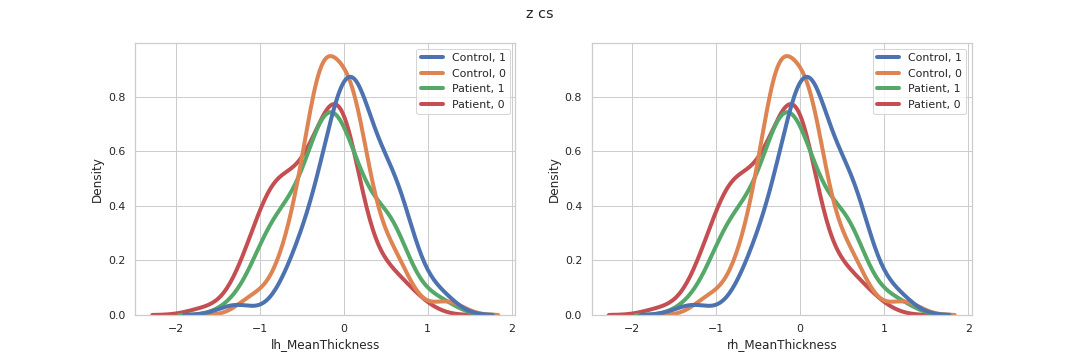

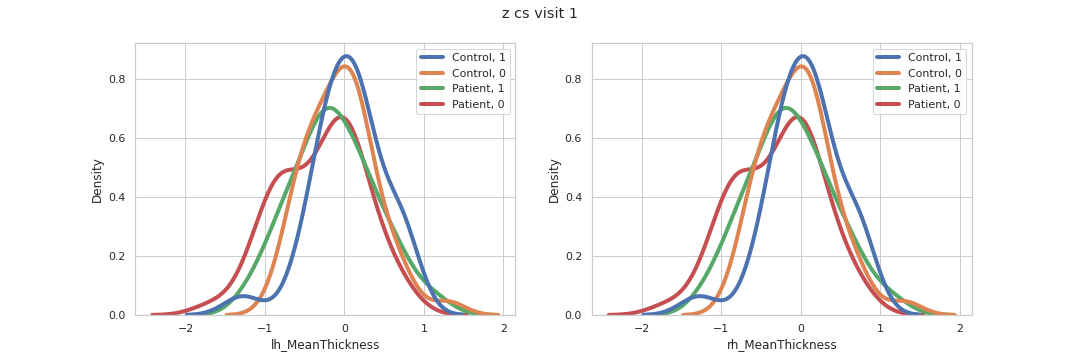

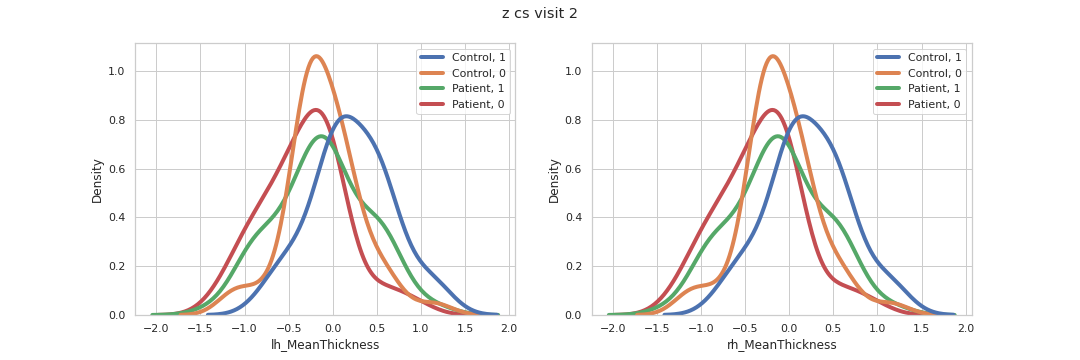

In [586]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

for i,id in enumerate(thick_id):
    data= data.sort_values(by=['sex'], ascending=True)
    data= data.sort_values(by=['Category'])

    hue = data['Category'].astype(str) +', ' + data['sex'].astype(str) 
    sns.kdeplot(data=data, x=id, hue=hue, ax=ax[i], linewidth=4, common_norm=False, hue_order=np.sort(hue.unique())[[1,0,3,2]])
    fig.suptitle(data_type + ' ' + preproc_type)



plt.savefig(os.path.join(images_dir, 'hist_'+preproc_type+'_'+data_type+'_cat_visit_sex_compar'))

fig, ax = plt.subplots(1,2, figsize = (15,5))

for i,id in enumerate(thick_id):
    #data= data.sort_values(by=['sex'], ascending=True)
    #data= data.sort_values(by=['Category'], ascending=True)

    hue = data['Category'].astype(str) +', ' + data['sex'].astype(str) 
    sns.kdeplot(data=data[data['visit']=='1'], x=id, hue=hue, ax=ax[i], linewidth=4, common_norm=False, hue_order=np.sort(hue.unique())[[1,0,3,2]])
    fig.suptitle(data_type + ' ' + preproc_type+ ' visit 1')


plt.savefig(os.path.join(images_dir, 'hist_'+preproc_type+'_'+data_type+'_cat_1_sex_compar'))


fig, ax = plt.subplots(1,2, figsize = (15,5))

for i,id in enumerate(thick_id):
    data= data.sort_values(by=['sex'], ascending=True)
    data= data.sort_values(by=['Category'])

    hue = data['Category'].astype(str) +', ' + data['sex'].astype(str) 
    sns.kdeplot(data=data[data['visit']=='2'], x=id, hue=hue, ax=ax[i], linewidth=4, common_norm=False, hue_order=np.sort(hue.unique())[[1,0,3,2]])
    fig.suptitle(data_type + ' ' + preproc_type + ' visit 2')


plt.savefig(os.path.join(images_dir, 'hist_'+preproc_type+'_'+data_type+'_cat_2_sex_compar'))

In [548]:
# split to patients and controls
#data = data[data['preproc']=='long']
v1_cont = data[(data['category']=='control') & (data['visit']=='1')]
v2_cont = data[(data['category']=='control') & (data['visit']=='2')]

v1_cont.index = v1_cont['index']
v2_cont.index = v2_cont['index']

v1_cont = v1_cont.sort_index()
v2_cont = v2_cont.sort_index()

v1_cont.index==v2_cont.index
cont_diff = v2_cont[thick_id]-v1_cont[thick_id]
cont_diff['category'] = 'cont'
cont_diff['sex'] = v1_cont['sex']

#
v1_pat = data[(data['category']=='patient') & (data['visit']=='1')]
v2_pat = data[(data['category']=='patient') & (data['visit']=='2')]

v1_pat.index = v1_pat['index']
v2_pat.index = v2_pat['index']

v1_pat = v1_pat.sort_index()
v2_pat = v2_pat.sort_index()

v1_pat.index==v2_pat.index
pat_diff = v2_pat[thick_id]-v1_pat[thick_id]
pat_diff['category'] = 'pat'
pat_diff['sex'] = v1_pat['sex']

data_merge = pd.concat([cont_diff, pat_diff])
data_merge = data_merge.reset_index()

data_merge = data_merge.sort_values(by=['category'])

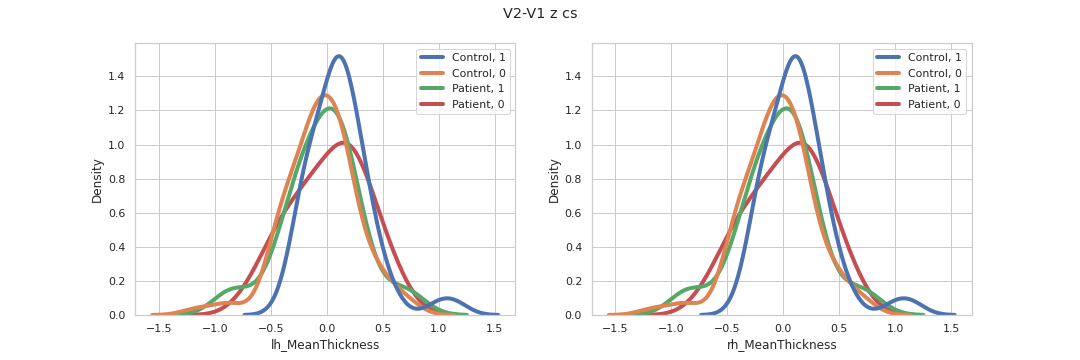

In [589]:

fig, ax = plt.subplots(1,2, figsize = (15,5))

for i,id in enumerate(thick_id):
    data= data.sort_values(by=['Category','sex'], ascending=True)

    hue = data['Category'].astype(str) +', ' + data['sex'].astype(str) 
    sns.kdeplot(data=data_merge, x=id, hue=hue, ax=ax[i], linewidth=4, common_norm=False, hue_order=np.sort(hue.unique())[[1,0,3,2]])
    fig.suptitle('V2-V1 '+data_type + ' ' + preproc_type )


plt.savefig(os.path.join(images_dir, 'hist_diff'+preproc_type+'_'+data_type+'_sex'))

**Computations using scraped header freesurfer data - at the end, I used only averaging of the IDPs**
------------------------------------------------------------------------------------------------------------

In [248]:
# Paths
data_dir = '/home/barbora/Documents/Projects/Normative_Models/ESO/backup/rough_metrics'
os.chdir(data_dir)
dirs = (glob.glob('*rough_metrics*'))

In [304]:
# clinics
clin = pd.read_excel('/home/barbora/Documents/Projects/Normative_Models/ESO/clinics.xlsx')
id = [i.lstrip('ESO') for i in clin.iloc[:,1]]
clin.index=id

clin['sex'] = 'F'
clin['sex'].loc[(clin[clin['Pohlaví'] == 'muž'].index)] = 'M'

/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [305]:
# load files with statistics
for edir, idir in enumerate(dirs):
    pk = pd.read_csv(idir, sep=' ')
    
    if idir.split('_')[0] == 'P':
        pk['category'] = 'patient'
    elif idir.split('_')[0] == 'C':
        pk['category'] = 'control'
    
    if idir.split('_')[1] == '1':
        pk['visit'] = '1'
    elif idir.split('_')[1] == '2':
        pk['visit'] = '2'

    if idir.split('_')[2] == 'cs':
        pk['preproc'] = 'cs'
    elif idir.split('_')[2] == 'long':
        pk['preproc'] = 'long'

    pk.index = pk['id']
    pk = pd.concat([pk,clin['sex']], axis=1, join='inner')

    if edir == 0:
        data = pk
    else:
        data = pd.concat([data,pk])

data = data.reset_index()
data.drop(columns='index', inplace=True)

data = data.sort_values(by=['category','visit','preproc'])

In [315]:
# split to patients and controls
#data = data[data['preproc']=='long']
v1_cont = data[(data['category']=='control') & (data['visit']=='1')]
v2_cont = data[(data['category']=='control') & (data['visit']=='2')]

v1_cont.index = v1_cont['id']
v2_cont.index = v2_cont['id']

v1_cont = v1_cont.sort_index()
v2_cont = v2_cont.sort_index()

v1_cont.index==v2_cont.index
cont_diff = v2_cont[thick_id]-v1_cont[thick_id]
cont_diff['category'] = 'cont'
cont_diff['preproc'] = v1_cont['preproc']
cont_diff['sex'] = v1_cont['sex']

#
v1_pat = data[(data['category']=='patient') & (data['visit']=='1')]
v2_pat = data[(data['category']=='patient') & (data['visit']=='2')]

v1_pat.index = v1_pat['id']
v2_pat.index = v2_pat['id']

v1_pat = v1_pat.sort_index()
v2_pat = v2_pat.sort_index()

v1_pat.index==v2_pat.index
pat_diff = v2_pat[thick_id]-v1_pat[thick_id]
pat_diff['category'] = 'pat'
pat_diff['preproc'] = v1_pat['preproc']
pat_diff['sex'] = v1_pat['sex']


In [335]:
data_merge = pd.concat([cont_diff, pat_diff])
data_merge = data_merge.reset_index()

data_merge = data_merge.sort_values(by=['category','preproc'])

In [317]:
#data_long = data[data['preproc']=='long']
data_long = data_merge[data_merge['preproc']=='long']

Comparison of the difference between patients and controls

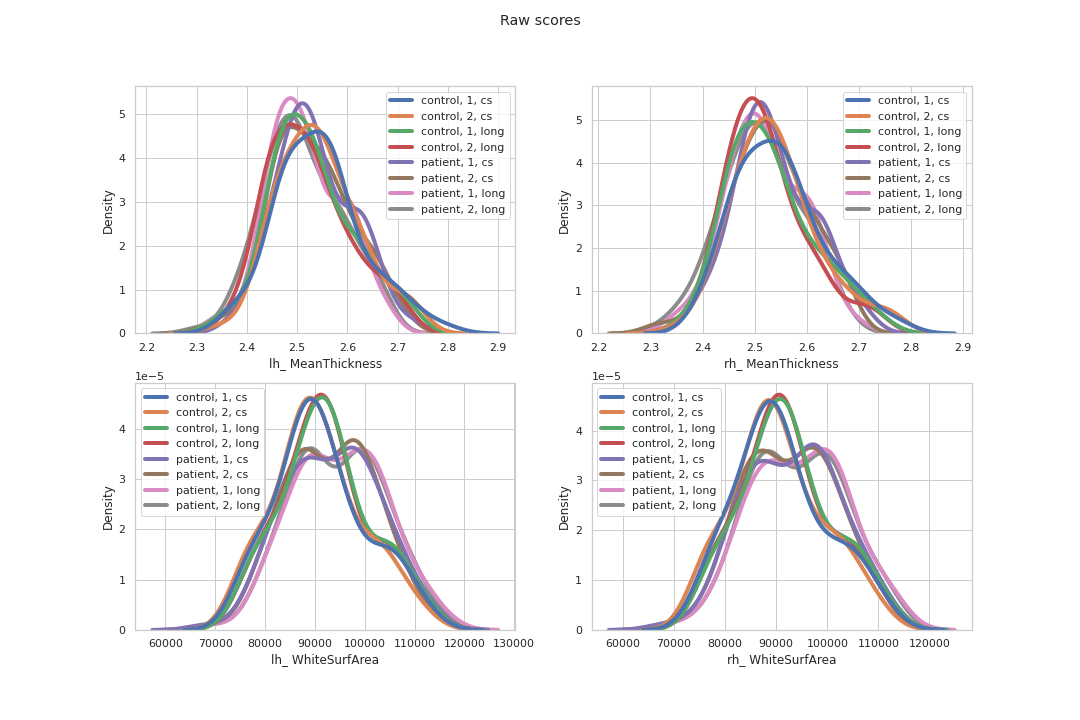

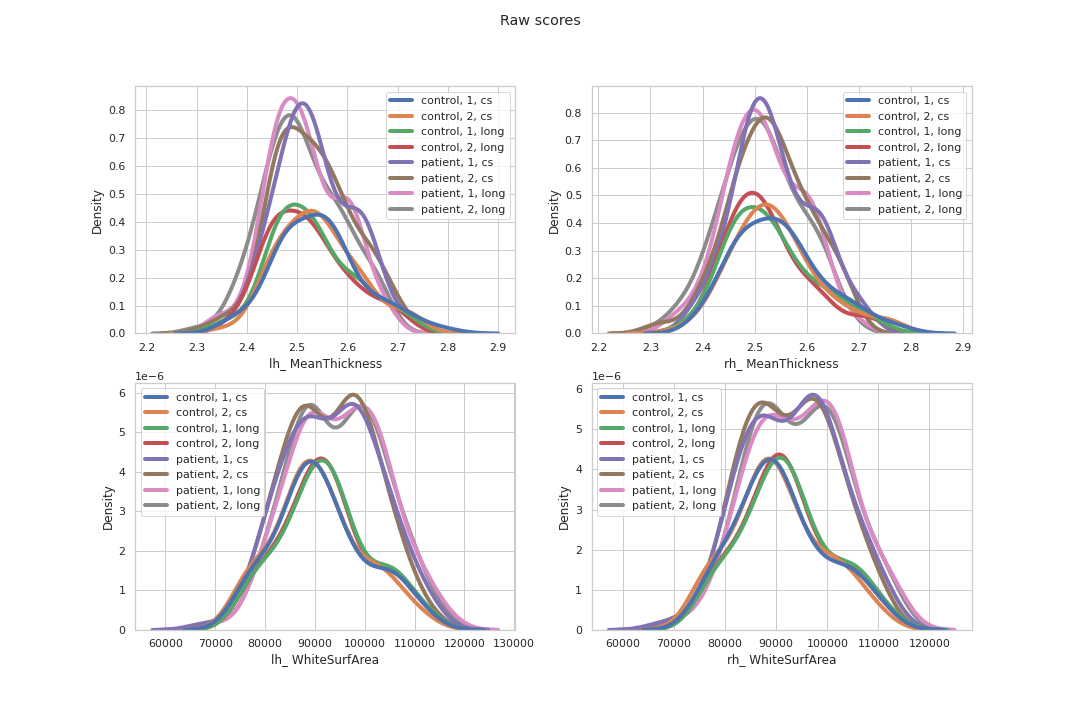

In [329]:
thick_id = ['lh_ MeanThickness', 'rh_ MeanThickness', 'lh_ WhiteSurfArea', 'rh_ WhiteSurfArea']

sns.set_theme(style="whitegrid", rc={"axes.facecolor": (1, 1, 1, 1)})

# Plot scraped info  
fig, ax = plt.subplots(2,2, figsize = (15,10))

for i,id in enumerate(thick_id):
    x = int(np.floor(i/2))
    y = np.mod(i,2)

    data = data.sort_values(by=['category', 'preproc', 'visit'])

    hue = data['category'].astype(str) + ', ' + data['visit'].astype(str) + ', ' + data['preproc'].astype(str)
    sns.kdeplot(data=data, x=id, hue=hue, ax=ax[x,y], linewidth=4, common_norm=False)
    fig.suptitle('Raw scores')

plt.savefig(os.path.join(images_dir, 'hist_raw_cat_vis_preproc'))

fig, ax = plt.subplots(2,2, figsize = (15,10))

# same hing with different norming
for i,id in enumerate(thick_id):
    x = int(np.floor(i/2))
    y = np.mod(i,2)

    data = data.sort_values(by=['category', 'preproc', 'visit'])

    hue = data['category'].astype(str) + ', ' + data['visit'].astype(str) + ', ' + data['preproc'].astype(str)
    sns.kdeplot(data=data, x=id, hue=hue, ax=ax[x,y], linewidth=4, common_norm=True)
    fig.suptitle('Raw scores')

plt.savefig(os.path.join(images_dir, 'hist_raw_cat_vis_preproc_not_common'))


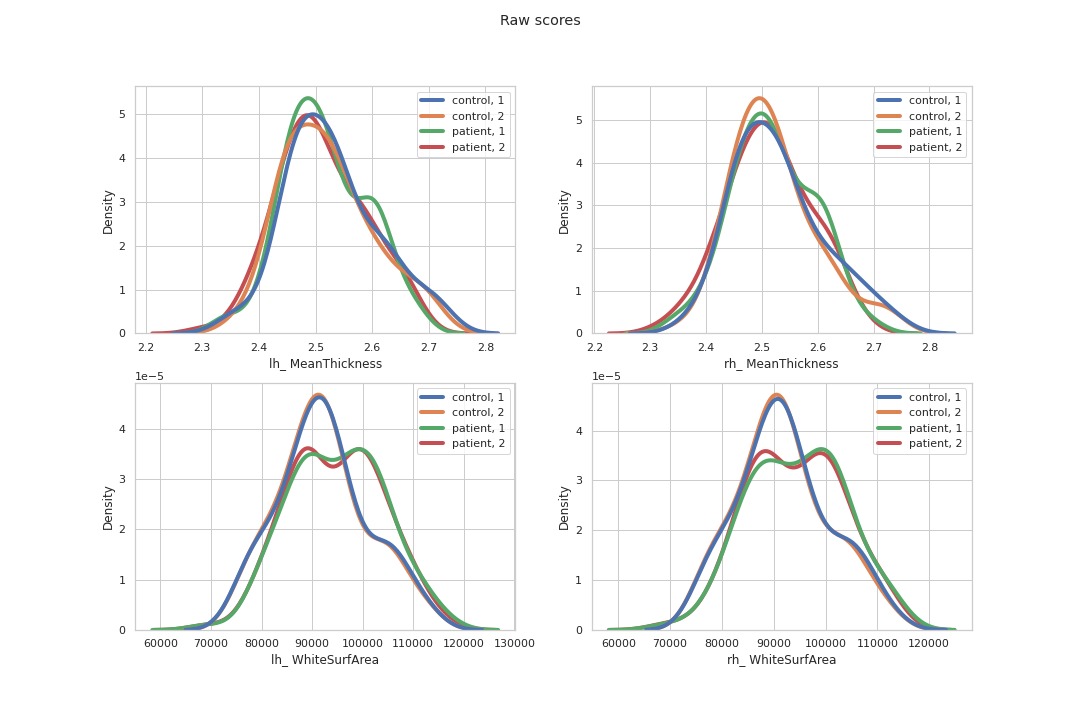

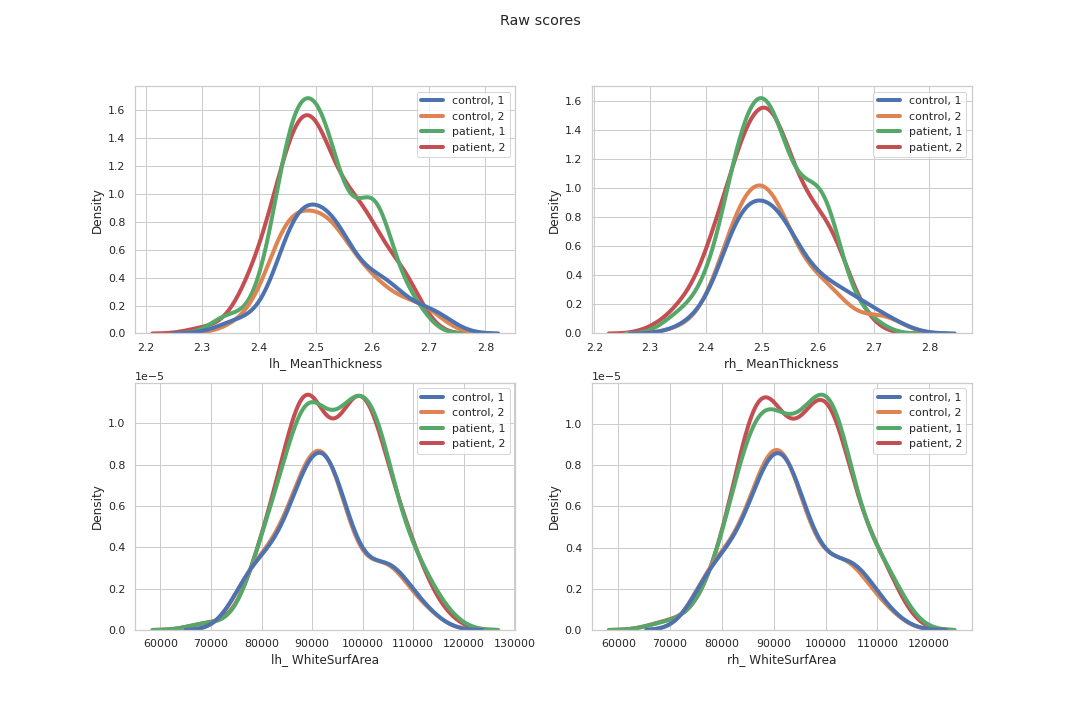

In [331]:
# Plot scraped info  
data_long = data[data['preproc']=='long']

fig, ax = plt.subplots(2,2, figsize = (15,10))

for i,id in enumerate(thick_id):
    x = int(np.floor(i/2))
    y = np.mod(i,2)

    data_long= data_long.sort_values(by=['category', 'visit'])

    hue = data_long['category'].astype(str) + ', ' + data_long['visit'].astype(str) 
    sns.kdeplot(data=data_long, x=id, hue=hue, ax=ax[x,y], linewidth=4, common_norm=False)
    fig.suptitle('Raw scores')

plt.savefig(os.path.join(images_dir, 'hist_raw_cat_vis'))

fig, ax = plt.subplots(2,2, figsize = (15,10))

# same hing with different norming
for i,id in enumerate(thick_id):
    x = int(np.floor(i/2))
    y = np.mod(i,2)

    data_long = data_long.sort_values(by=['category', 'visit'])

    hue = data_long['category'].astype(str) + ', ' + data_long['visit'].astype(str) 
    sns.kdeplot(data=data_long, x=id, hue=hue, ax=ax[x,y], linewidth=4, common_norm=True)
    fig.suptitle('Raw scores')

plt.savefig(os.path.join(images_dir, 'hist_raw_cat_vis_not_common'))

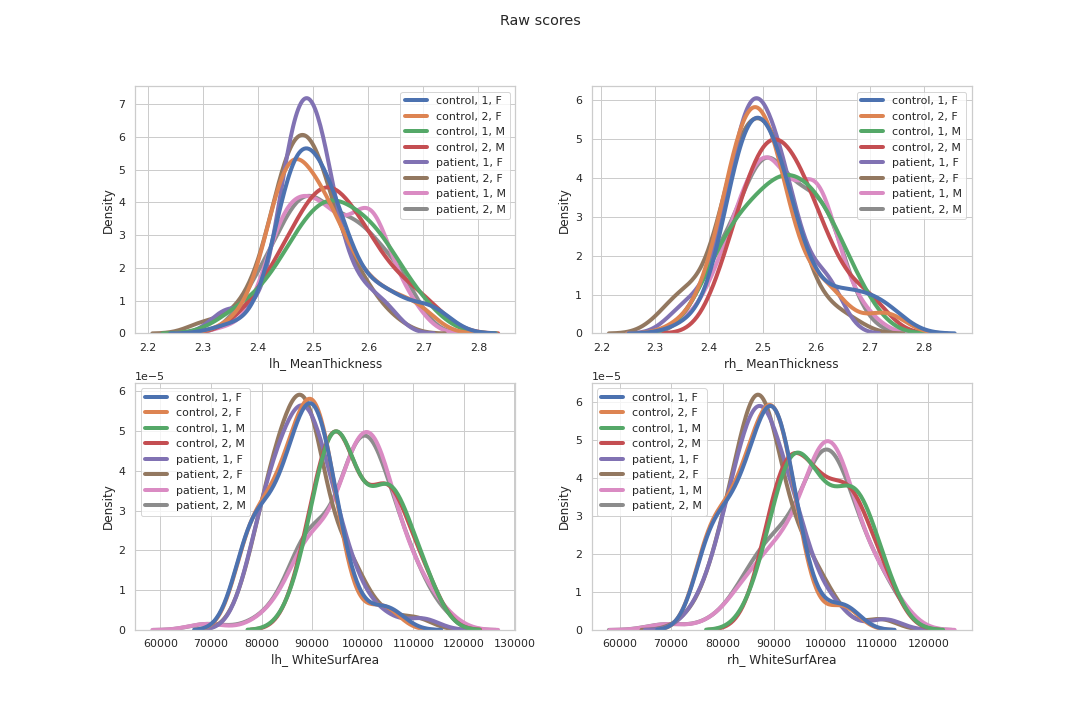

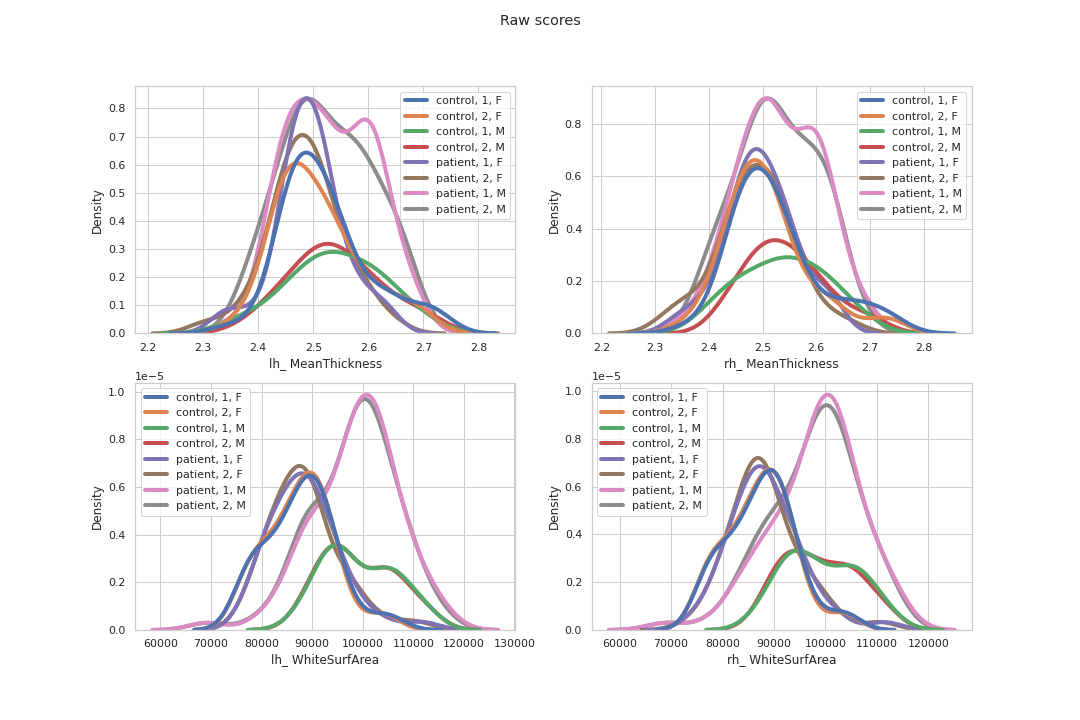

In [332]:
# Plot scraped info  
data_long = data[data['preproc']=='long']

fig, ax = plt.subplots(2,2, figsize = (15,10))

for i,id in enumerate(thick_id):
    x = int(np.floor(i/2))
    y = np.mod(i,2)

    data_long= data_long.sort_values(by=['category', 'sex', 'visit'])

    hue = data_long['category'].astype(str) + ', ' + data_long['visit'].astype(str) + ', ' + data_long['sex'].astype(str) 
    sns.kdeplot(data=data_long, x=id, hue=hue, ax=ax[x,y], linewidth=4, common_norm=False)
    fig.suptitle('Raw scores')

plt.savefig(os.path.join(images_dir, 'hist_raw_cat_vis_sex'))

fig, ax = plt.subplots(2,2, figsize = (15,10))

# same hing with different norming
for i,id in enumerate(thick_id):
    x = int(np.floor(i/2))
    y = np.mod(i,2)

    data_long = data_long.sort_values(by=['category', 'sex', 'visit'])

    hue = data_long['category'].astype(str) + ', ' + data_long['visit'].astype(str) + ', ' + data_long['sex'].astype(str) 
    sns.kdeplot(data=data_long, x=id, hue=hue, ax=ax[x,y], linewidth=4, common_norm=True)
    fig.suptitle('Raw scores')

plt.savefig(os.path.join(images_dir, 'hist_raw_cat_vis_sex_not_common'))

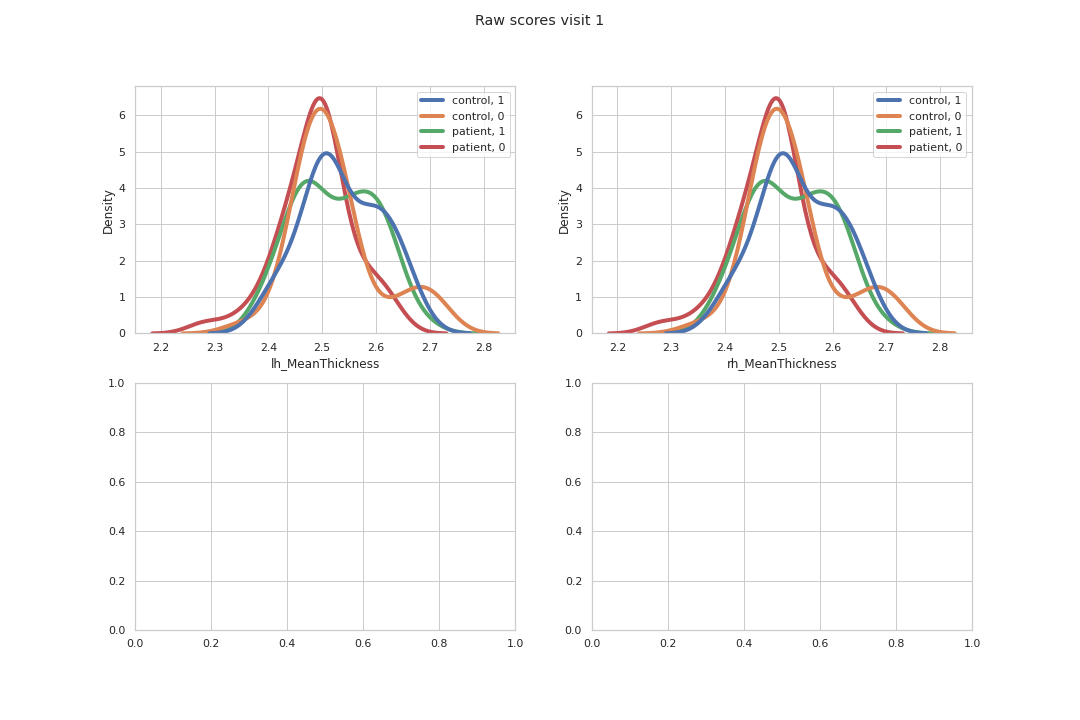

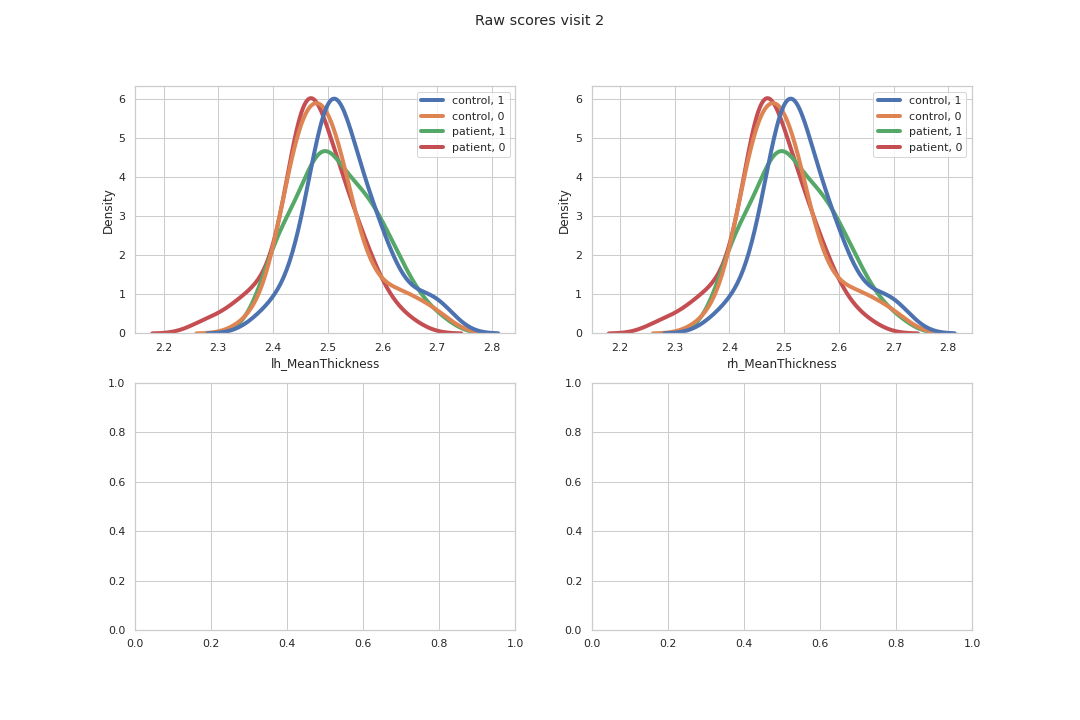

In [454]:
# Plot scraped info  
data_long = data[data['preproc']=='long']

fig, ax = plt.subplots(2,2, figsize = (15,10))

for i,id in enumerate(thick_id):
    x = int(np.floor(i/2))
    y = np.mod(i,2)

    data_long= data_long.sort_values(by=['category', 'sex', 'visit'])

    hue = data_long['category'].astype(str) + ', ' + data_long['sex'].astype(str) 
    sns.kdeplot(data=data_long[data_long['visit']=='1'], x=id, hue=hue, ax=ax[x,y], linewidth=4, common_norm=False)
    fig.suptitle('Raw scores visit 1')

plt.savefig(os.path.join(images_dir, 'hist_raw_cat_1_sex'))

fig, ax = plt.subplots(2,2, figsize = (15,10))


for i,id in enumerate(thick_id):
    x = int(np.floor(i/2))
    y = np.mod(i,2)

    data_long= data_long.sort_values(by=['category', 'sex', 'visit'])

    hue = data_long['category'].astype(str) + ', ' + data_long['sex'].astype(str) 
    sns.kdeplot(data=data_long[data_long['visit']=='2'], x=id, hue=hue, ax=ax[x,y], linewidth=4, common_norm=False)
    fig.suptitle('Raw scores visit 2')

plt.savefig(os.path.join(images_dir, 'hist_raw_cat_2_sex'))



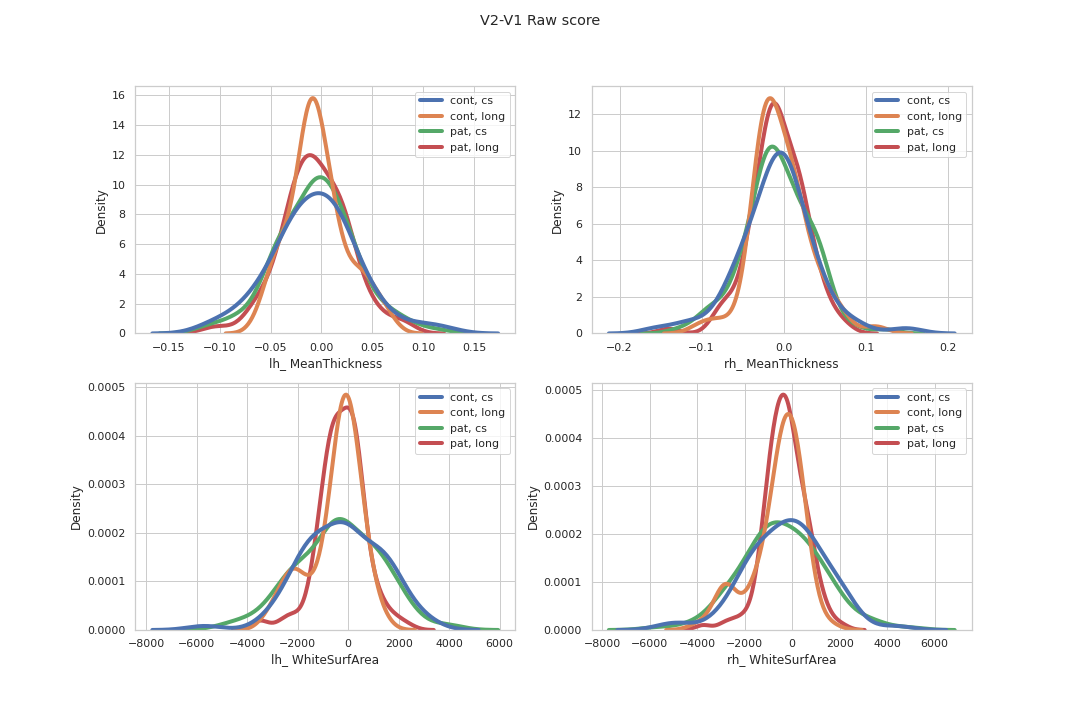

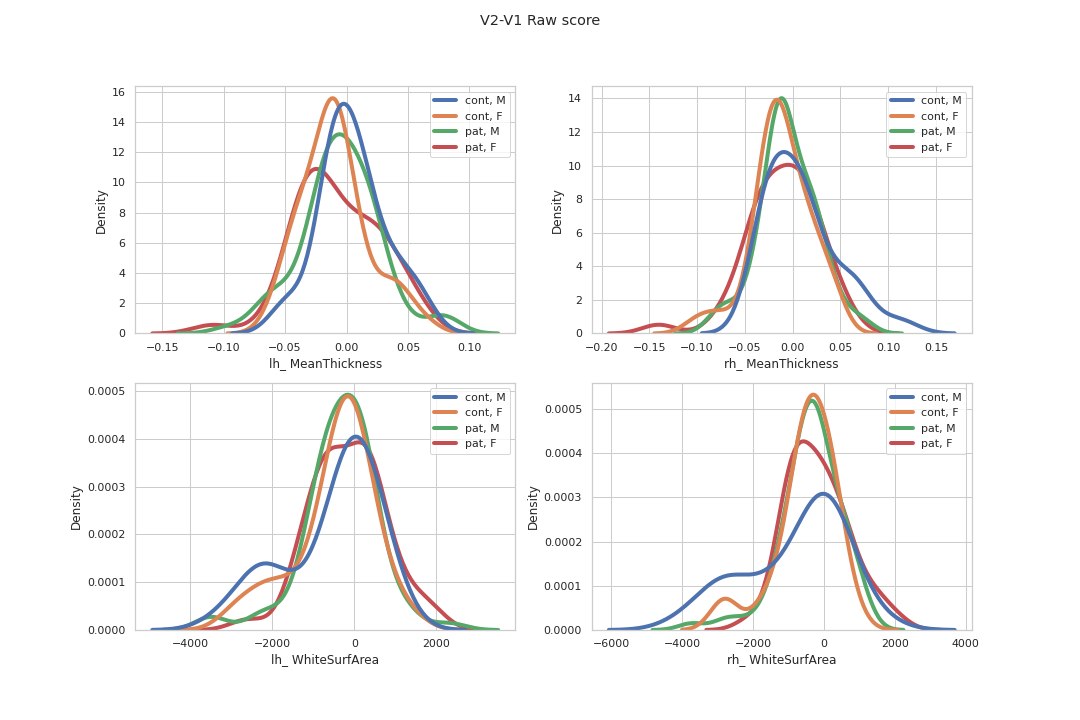

In [339]:
thick_id = ['lh_ MeanThickness', 'rh_ MeanThickness', 'lh_ WhiteSurfArea', 'rh_ WhiteSurfArea']

sns.set_theme(style="whitegrid", rc={"axes.facecolor": (1, 1, 1, 1)})

# Plot scraped info  
fig, ax = plt.subplots(2,2, figsize = (15,10))

for i,id in enumerate(thick_id):
    x = int(np.floor(i/2))
    y = np.mod(i,2)

    data_merge = data_merge.sort_values(by=['category', 'preproc'])

    hue = data_merge['category'].astype(str) + ', ' + data_merge['preproc'].astype(str)
    sns.kdeplot(data=data_merge, x=id, hue=hue, ax=ax[x,y], linewidth=4, common_norm=False)

    fig.suptitle('V2-V1 Raw score')

plt.savefig(os.path.join(images_dir, 'diff_scraped_hist_diff_preproc'))

fig, ax = plt.subplots(2,2, figsize = (15,10))
for i,id in enumerate(thick_id):
    x = int(np.floor(i/2))
    y = np.mod(i,2)

    data_merge = data_merge.sort_values(by=['category', 'preproc'])

    hue = data_merge['category'].astype(str) + ', ' + data_merge['sex'].astype(str)
    sns.kdeplot(data=data_merge[data_merge['preproc']=='long'], x=id, hue=hue, ax=ax[x,y], linewidth=4, common_norm=False)

    fig.suptitle('V2-V1 Raw score')

plt.savefig(os.path.join(images_dir, 'diff_scraped_hist_diff_sex'))